In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [3]:
from ml.model import U_Net
from ml.utils import get_total_params

from scripts.load_and_save import (get_dcm_info, get_dcm_vol, vox_size2affine,
                                   save_vol_as_nii, load_sample_data)
from scripts.load_and_save import load_nii_vol, save_vol_as_nii, load_sample_data

from ml.dataset import preprocess_dataset, HVB_Dataset

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
PATCH_SHAPE = (64, 64, 64)

In [6]:
dataset_settings = {
    "data_dir" : "/home/msst/Documents/medtech/brain_seg_dataset",
    "patch_shape" : PATCH_SHAPE,
    "number_of_patches" : 4,
    "mode": "train",
    "RAM_samples" : True 
}
patch_data_df, sample_data_df = preprocess_dataset(dataset_settings)
dataset = HVB_Dataset(dataset_settings)

In [7]:
loader_params = {"batch_size": 6,
                 "shuffle": True,
                 "num_workers": 6
                }

dataloader = DataLoader(dataset, **loader_params)

In [8]:
for batch in dataloader:
    head_batch = batch['head_patch']
    vessels_batch = batch['vessels_patch']
    brain_batch = batch['brain_patch']
    
    print(head_batch.shape)
    print(vessels_batch.shape)
    print(brain_batch.shape)
    break

torch.Size([6, 1, 64, 64, 64])
torch.Size([6, 1, 64, 64, 64])
torch.Size([6, 1, 64, 64, 64])


In [9]:
model = U_Net()

In [10]:
get_total_params(model)

103536449

In [11]:
model = model.to(device)

In [12]:
loss_fn = nn.BCELoss(reduction='mean')
optim = torch.optim.Adam(model.parameters(), lr=3e-4)

In [13]:
for epoch in range(50):
    model.train()
    losses = []
    for batch in dataloader:
        head_batch = batch['head_patch'].to(device)
        vessels_batch = batch['vessels_patch'].to(device)
        
        optim.zero_grad()
        output = model.forward(head_batch)
        output = output[0]    

        loss_train = loss_fn(output, vessels_batch)

        loss_train.backward()
        optim.step()
        losses.append(loss_train.item())
    print(f"epoch: {epoch},", f"loss: {sum(losses)/len(losses)}")
    
model.eval()

epoch: 0, loss: 0.7297135889530182
epoch: 1, loss: 0.6528860926628113
epoch: 2, loss: 0.5335889458656311
epoch: 3, loss: 0.4858166575431824
epoch: 4, loss: 0.5267638862133026
epoch: 5, loss: 0.4351470023393631
epoch: 6, loss: 0.43001171946525574
epoch: 7, loss: 0.4119606614112854
epoch: 8, loss: 0.3940429538488388
epoch: 9, loss: 0.38517192006111145
epoch: 10, loss: 0.37457995116710663
epoch: 11, loss: 0.36777348816394806
epoch: 12, loss: 0.3621393144130707
epoch: 13, loss: 0.35381749272346497
epoch: 14, loss: 0.3474697321653366
epoch: 15, loss: 0.34112802147865295
epoch: 16, loss: 0.3370096981525421
epoch: 17, loss: 0.3389808237552643
epoch: 18, loss: 0.33059900999069214
epoch: 19, loss: 0.3273228257894516
epoch: 20, loss: 0.3223413825035095
epoch: 21, loss: 0.31514105200767517
epoch: 22, loss: 0.3162900060415268
epoch: 23, loss: 0.30961886048316956
epoch: 24, loss: 0.30250248312950134
epoch: 25, loss: 0.300421878695488
epoch: 26, loss: 0.29487156867980957
epoch: 27, loss: 0.291824087

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [19]:
def save_model(model, path_to_save_model, name):
    os.makedirs(path_to_save_model, exist_ok=True)
    torch.save(model.state_dict(), path_to_save_model + "/" + name) 

In [20]:
save_model(model, './models', "compressed")

In [12]:
model.load_state_dict(torch.load("/home/msst/repo/MSRepo/VesselSegmentation/models/compressed"))

<All keys matched successfully>

In [13]:
print(head_vol.shape)
cut_head_vol = head_vol
print(cut_head_vol.shape)

torch.Size([1, 256, 256, 192])
torch.Size([1, 256, 256, 192])


In [14]:
device = 'cpu'
model = model.to(device)

In [15]:
model_brain_seg = None
with torch.no_grad():
    model.eval()
    model_brain_seg = model(cut_head_vol.unsqueeze(0).to(device))
    model_brain_seg = model_brain_seg[0].cpu()

In [31]:
model_brain_seg = model_brain_seg[0, 0, :, :, :].numpy()
model_brain_seg[model_brain_seg<0.5] = 0
model_brain_seg[model_brain_seg>0] = 1
model_brain = cut_head_vol[0, :, :, :].numpy()

In [32]:
print(model_brain_seg.shape)
print(model_brain.shape)


(256, 256, 192)
(256, 256, 192)


In [33]:
data_dir = "seg_data/CT_S5020"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

path_to_brain = path_to_folder + "/brain.nii.gz" 
head_file = nib.load(path_to_brain)


path_to_save_brain = data_dir + '/comp_brain.nii.gz'
path_to_save_seg = data_dir + '/comp_brain_seg.nii.gz'

save_vol_as_nii(model_brain, head_file.affine, path_to_save_brain)
save_vol_as_nii(model_brain_seg, head_file.affine, path_to_save_seg)

In [26]:
import matplotlib.pyplot as plt
def print_img(vol, axis, title= 'title', slice=None, cmap='hot'):
    global SHOW_SLICE
    axis.set_title(title)
    if slice is None:
        im = axis.imshow(vol[:, :, SHOW_SLICE], cmap=cmap)
    else: 
        im = axis.imshow(vol[:, :, slice], cmap=cmap)
    plt.colorbar(im)

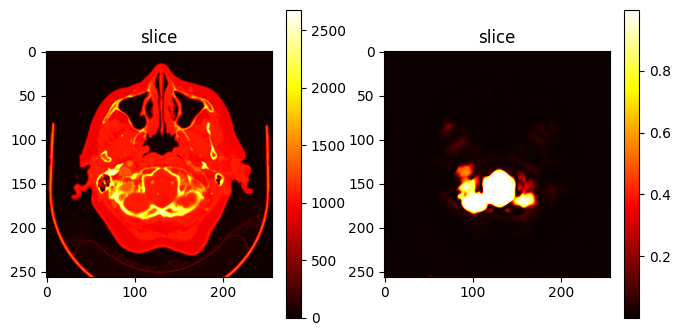

In [27]:
SHOW_SLICE = 31

fig, ax = plt.subplots(1, 2, figsize=(8, 4))    
print_img(model_brain, ax[0], 'slice')    
print_img(model_brain_seg, ax[1], 'slice')  

In [10]:
def normalize_vol(vol):
    return (vol - vol.mean()) / vol.std()